# RNN & LSTM

RNNs have a simple recurrent structure with unidirectional information flow. 

LSTMs have a gating mechanism that controls information flow and a cell state for long-term memory.

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math
import datetime
import keras

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Python version: 3.10.5
Tensorflow version: 2.13.0
Keras version: 2.13.1


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Generate a dataset

In [3]:
dataset_size = 10000
sequence_length = 4
max_num = 200

In [4]:
def generate_sums(dataset_size, sequence_length, max_num):
    x, y = [], []

    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [5]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:4])
print()
print('y_train:\n', y_train[:4])

x_train:
 [[186, 24, 155, 39], [153, 65, 129, 58], [152, 43, 42, 14], [51, 15, 65, 98]]

y_train:
 [404, 405, 251, 229]


In [6]:
import math

def dataset_to_strings(x, y, max_num):
    sequence_length = len(x[0])
    num_chars_per_digit = len(str(max_num))
    max_x_length = sequence_length * num_chars_per_digit + (sequence_length - 1)
    max_y_length = len(str(sequence_length * max_num))
    
    x_str = [" ".join(f"{num:>{num_chars_per_digit}}" for num in example).replace(" ", "+")
             .ljust(max_x_length) for example in x]
    
    y_str = [str(label).ljust(max_y_length) for label in y]
    
    return x_str, y_str

In [7]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['186++24+155++39' '153++65+129++58' '152++43++42++14']

y_train_str:
 ['404' '405' '251']


In [8]:
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [9]:
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


In [10]:
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [11]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 1  8  6 10 10  2  4 10  1  5  5 10 10  3  9]
 [ 1  5  3 10 10  6  5 10  1  2  9 10 10  5  8]
 [ 1  5  2 10 10  4  3 10 10  4  2 10 10  1  4]]

y_train_encoded:
 [[4 0 4]
 [4 0 5]
 [2 5 1]]


In [12]:
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [13]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]]]

y_train_one_hot:
 [[[0 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]]]


In [14]:
# Generates a dataset.
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    x, y = dataset_to_strings(x, y, max_num)
    x, y = dataset_to_indices(x, y, vocabulary)
    x, y = dataset_to_one_hot(x, y, vocabulary)
    return np.array(x), np.array(y)

In [15]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]]]

y:
 [[[0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]]]


In [16]:
print('x.shape: ', x.shape) 
print('y.shape: ', y.shape) 

x.shape:  (10000, 15, 12)
y.shape:  (10000, 3, 12)


In [17]:
input_sequence_length = x.shape[1]
output_sequence_length = y.shape[1]
supported_symbols_num = x.shape[2]
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  15
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [18]:
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [19]:
decode(y[0], vocabulary)

'349'

## Build a model

In [20]:
epochs_num = 100
batch_size = 64

In [21]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 128)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            131584    
                                                                 
 time_distributed (TimeDist  (None, 3, 12)             1548      
 ributed)                                                        
                                                                 
 activation (Activation)     (None, 3, 12)             0         
                                                                 
Total params: 205324 (802.05 KB)
Trainable params: 20532

## Train a model

In [23]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'],
)

In [24]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [25]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
141/141 [==============================] - 10s 37ms/step - loss: 2.1430 - accuracy: 0.1630 - val_loss: 2.0845 - val_accuracy: 0.1623
Epoch 2/100
141/141 [==============================] - 4s 27ms/step - loss: 2.0795 - accuracy: 0.1689 - val_loss: 2.0817 - val_accuracy: 0.1693
Epoch 3/100
141/141 [==============================] - 4s 27ms/step - loss: 2.0569 - accuracy: 0.1764 - val_loss: 2.0099 - val_accuracy: 0.2240
Epoch 4/100
141/141 [==============================] - 4s 29ms/step - loss: 1.9008 - accuracy: 0.2505 - val_loss: 1.8565 - val_accuracy: 0.2717
Epoch 5/100
141/141 [==============================] - 4s 29ms/step - loss: 1.8208 - accuracy: 0.2835 - val_loss: 1.7953 - val_accuracy: 0.2850
Epoch 6/100
141/141 [==============================] - 4s 29ms/step - loss: 1.7874 - accuracy: 0.2965 - val_loss: 1.7577 - val_accuracy: 0.3140
Epoch 7/100
141/141 [==============================] - 4s 29ms/step - loss: 1.7354 - accuracy: 0.3199 - val_loss: 1.7138 - val_accuracy

In [27]:
def render_training_history(training_history):
    loss = training_history.history.get('loss', [])
    val_loss = training_history.history.get('val_loss', [])

    accuracy = training_history.history.get('accuracy', [])
    val_accuracy = training_history.history.get('val_accuracy', [])

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training Loss', color='blue', marker='o')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--', marker='s')
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.7, alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training Accuracy', color='green', marker='o')
    if val_accuracy:
        plt.plot(val_accuracy, label='Validation Accuracy', color='orange', linestyle='--', marker='s')
    plt.legend()
    plt.grid(linestyle='--', linewidth=0.7, alpha=0.7)

    plt.show()


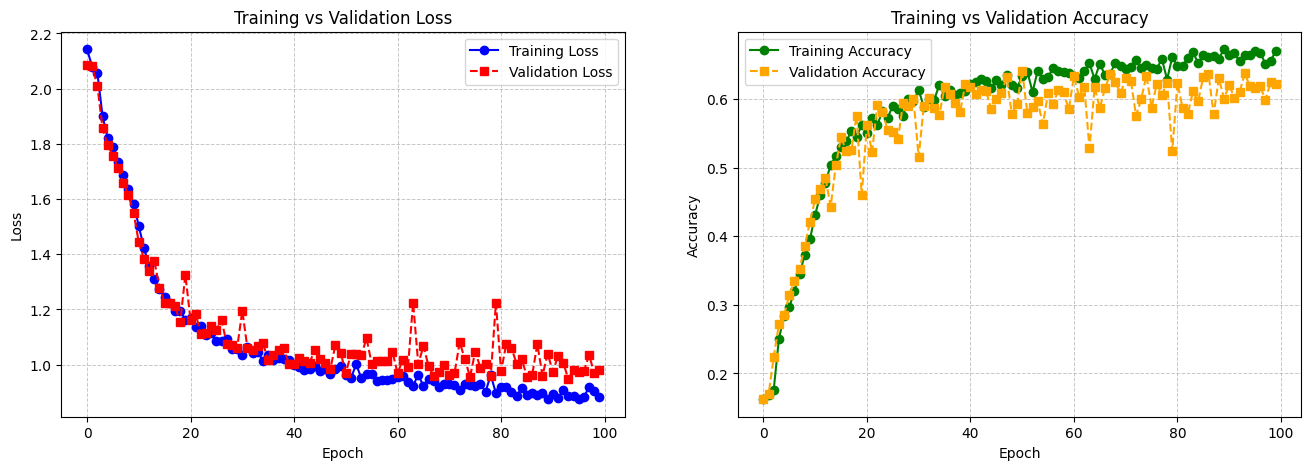

In [28]:
render_training_history(history)

## Test a dataset

In [29]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]]]

y_test:
 [[[0 0 0 1 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]]]


In [30]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

313/313 [==============================] - 8s 15ms/step
predictions.shape:  (10000, 3, 12)

predictions[0]:
 [[1.32786143e-12 6.80711376e-10 1.42108295e-02 9.84326303e-01
  1.46275235e-03 1.27262098e-07 5.18469165e-12 2.14348159e-14
  5.25137994e-17 8.34030409e-16 1.45195418e-11 1.78698189e-13]
 [9.48410690e-01 4.01597060e-02 1.06576852e-04 9.56139843e-07
  6.29729087e-08 4.45923254e-09 1.71485770e-09 7.04363785e-08
  2.81244320e-05 1.12937391e-02 9.09924371e-13 2.44532467e-11]
 [1.27058327e-01 1.19746722e-01 3.91479731e-02 8.54896456e-02
  1.38178721e-01 1.79917231e-01 1.44319713e-01 6.84800297e-02
  5.32791913e-02 4.43824008e-02 1.06229574e-10 3.10008108e-09]]

predictions[1]:
 [[1.97036079e-05 5.11834361e-02 9.47843671e-01 9.27225046e-04
  2.53341677e-05 2.62329308e-07 5.20087333e-08 5.66889931e-08
  9.18482073e-08 2.61892609e-07 5.89771898e-10 5.18681868e-11]
 [8.37724924e-01 1.25900269e-01 2.14558933e-03 1.66114114e-04
  1.41141909e-05 5.35598588e-07 7.50184995e-07 1.96419023e-05


In [31]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 30
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

193++23++24++67 = 307 [predict: 305] 
+48++79++69+++8 = 204 [predict: 209] 
129+146+108++36 = 419 [predict: 416] 
110+184+187++59 = 540 [predict: 536] 
133+113++70++71 = 387 [predict: 384] 
171+198+146+127 = 642 [predict: 634] 
+33++25++61++34 = 153 [predict: 155] 
136+118+154++55 = 463 [predict: 455] 
+51++73+151+106 = 381 [predict: 386] 
+98+115+140++96 = 449 [predict: 445] 
127+138++39++71 = 375 [predict: 374] 
+99++44+127+125 = 395 [predict: 396] 
134+125++45++90 = 394 [predict: 395] 
++7+158+105+193 = 463 [predict: 461] 
100++48+139+163 = 450 [predict: 445] 
134+156++19++75 = 384 [predict: 384] ✓
108+++5++39+161 = 313 [predict: 311] 
+50+195++31+192 = 468 [predict: 466] 
+35+195+133+126 = 489 [predict: 488] 
149++37+189+196 = 571 [predict: 561] 
141++13++47+172 = 373 [predict: 365] 
+28++11+122+157 = 318 [predict: 315] 
+95+136+154+133 = 518 [predict: 513] 
+98++64++96+119 = 377 [predict: 376] 
+21+138+126+108 = 393 [predict: 396] 
110++83++68+166 = 427 [predict: 429] 
188++19+136

## Save a model

In [32]:
model_name = 'numbers_summation_rnn.h5'
model.save(model_name, save_format='h5')